In [1]:
#attempt to run model

#import statements
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
import math
import tensorflow.keras.layers as layers
import pandas as pd
import IPython.display as dis
from PIL import Image

In [2]:
#functions for drawing
def show_byte_img(arr, name='temp.png', **args):
    clip_lo, clip_hi = np.array([np.sum(arr < 0), np.sum(arr > 256)]) * 100 / arr.size
    print(f'clipping low/high: {clip_lo:.1f}% {clip_hi:.1f}%')
    b = arr.clip(min=0, max=255).astype('uint8')
    Image.fromarray(b).save(name)
    dis.display(dis.Image(name, **args))

def standardize(arr, mean=150, std_dev=50, invert=1):
    norm = (arr - arr.mean()) / arr.std()
    return (norm * invert * std_dev) + mean

def scale(arr, percent_tail=2, percent_top=None, invert=False):
    left, right = (percent_tail/2, percent_tail/2) if percent_top is None \
                  else (percent_tail, percent_top)
    norm = (arr - arr.mean()) / arr.std()
    normi = norm * (1 if not invert else -1)
    sort_arr = np.sort(normi.flatten())
    left, right = int(sort_arr.size * left / 100), int(sort_arr.size * right / 100)
    print(f'left={left} right={right}')
    lo, hi = sort_arr[left], sort_arr[-(1 + right)]
    byte_scale = 256 / (hi - lo)
    offset = 0 - lo * byte_scale
    print(f'byte_scale={byte_scale:.2f} offset={offset:.2f}')
    return (normi * byte_scale) + offset

In [ ]:
#load data
case=np.load('EMAfullcase_normalized.npz')
case.files

In [8]:
predictand_label='DNB_full_moon_norm'

In [ ]:
#put in predictors and predictands
 #will become an argument when executable
TORS= case['M15norm'].flatten() # M15 
TAND= case[predictand_label].flatten() # DNBFMN
fixshape = case['latitude'].shape
case['latitude'].shape,TORS.shape, TAND.shape

In [ ]:
#test train split
from sklearn.model_selection import train_test_split
# Split into training and testing data
TORS_train, TORS_test, TAND_train, TAND_test = train_test_split(TORS, TAND, test_size=0.20) #, random_state=random_state)
#TORS_train, TORS_test, TAND_train, TAND_test = TORS[:train],TORS[train:],TAND[:train],TAND[train:]
TORS_train.shape, TORS_test.shape, TAND_train.shape, TAND_test.shape
#model

In [ ]:
#command for the GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

#number of nodes
n_units = 4

model = tf.keras.Sequential()
# First hidden layer:
model.add(layers.Dense(n_units, activation='relu', input_shape=(1,) ))
# Second hidden layer:
model.add(layers.Dense(n_units, activation='relu'))
# Output layer:  just 1 node and no activation function
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer=keras.optimizers.Adam(0.01),  # Adam optimizer
            loss='mse',       # mean squared error
           metrics=['mae','mse'])  # mean absolute error


In [ ]:
n_epochs = 3   # 250
history = model.fit(TORS_train, TAND_train,validation_data =(TORS_test,TAND_test), epochs=n_epochs, batch_size=1000)   #validation_split=0.30


In [ ]:
model.save('FNN_cole4')

In [3]:
#load model when i have picked up from earlier
from tensorflow import keras
model = tf.keras.models.load_model('FNN_cole4')


In [5]:
print(model)

In [ ]:
#lets predict on all the original input (test and train) 
#predict on unshuffled data
limit = 3056*3759
model_output= model.predict(TORS)


In [ ]:
model_outputfinal= model_output.reshape(fixshape)
model_outputfinal.shape
np.savez(f"EMA_ML_truth_{predictand_label}", MLtruth = model_outputfinal)

In [9]:
#onramp to load the ML truths and do post process analysis

#load predictors/tand
inputs=np.load('EMAfullcase_normalized.npz')
#load MLstuff
ML=np.load(f"EMA_ML_truth_{predictand_label}.npz")
inputs.files, ML.files

(['latitude',
  'longitude',
  'DNB',
  'M12',
  'M13',
  'M14',
  'M15',
  'M16',
  'channels',
  'samples',
  'M12norm',
  'M13norm',
  'M14norm',
  'M15norm',
  'M16norm',
  'BTD1213',
  'BTD1213norm',
  'BTD1214',
  'BTD1214norm',
  'BTD1215',
  'BTD1215norm',
  'BTD1216',
  'BTD1216norm',
  'BTD1312',
  'BTD1312norm',
  'BTD1314',
  'BTD1314norm',
  'BTD1315',
  'BTD1315norm',
  'BTD1316',
  'BTD1316norm',
  'BTD1412',
  'BTD1412norm',
  'BTD1413',
  'BTD1413norm',
  'BTD1415',
  'BTD1415norm',
  'BTD1416',
  'BTD1416norm',
  'BTD1512',
  'BTD1512norm',
  'BTD1513',
  'BTD1513norm',
  'BTD1514',
  'BTD1514norm',
  'BTD1516',
  'BTD1516norm',
  'BTD1612',
  'BTD1612norm',
  'BTD1613',
  'BTD1613norm',
  'BTD1614',
  'BTD1614norm',
  'BTD1615',
  'BTD1615norm',
  'DNBfix',
  'DNB_norm',
  'DNB_full_moon_norm',
  'DNB_log_norm',
  'DNB_log_full_moon_norm',
  'DNB_log_Miller_full_moon'],
 ['MLtruth'])

In [10]:
ML['MLtruth'].shape, inputs['latitude'].shape

((5, 3056, 3759), (5, 3056, 3759))

In [31]:
#MLtruth and DNB where DNBlFMN >0.5
CLOUD = inputs['DNB_log_full_moon_norm'].flatten() >0.5
percent = np.count_nonzero(CLOUD)/len(CLOUD)#percent above the threshold given
print(percent)



0.4668193717277487


In [37]:
CLOUD.shape, ML['MLtruth'].shape, inputs['latitude'].shape

((57437520,), (5, 3056, 3759), (5, 3056, 3759))

<AxesSubplot:>

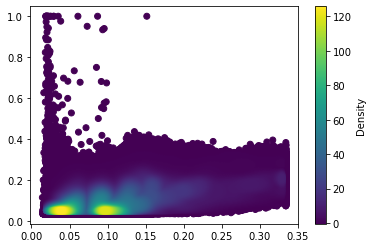

In [40]:
#scatter plot of values where most liekly not clear
x = ML['MLtruth'].flatten()[CLOUD]
y = inputs ['DNB_full_moon_norm'].flatten()[CLOUD]

from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 1000, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    #add labels
    return ax

density_scatter( x, y, bins = [30,30] )



In [ ]:
limits=10_000_000
#grab a random sample of size limits and make x/y

xx = inputs[predictand_label].flatten()
yy = ML['MLtruth'].flatten()

indicies = np.random.choice(len(xx), limits, replace = False)
x = xx[indicies]
y = yy[indicies]


In [ ]:
#density scatter plot for larger datsets
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 1000, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    #add labels
    return ax

density_scatter( x, y, bins = [30,30] )

In [ ]:
#hexbin instead of scatter plot

#plt.hexbin(x, y, C=None, gridsize=100, bins=None, xscale='linear', yscale='linear', extent=None, cmap=None, norm=None, 
#vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors='face', reduce_C_function=<function mean>, mincnt=None, marginals=False, *, data=None, **kwargs)

plt.hexbin(x,y, edgecolors = None, label='normalized DNB')#alpha =.002,
plt.xlabel('X value = Truth DNB')
plt.ylabel('Y value = ML DNB')
plt.legend()
plt.title('truth DNB vs ML DNB for Full Moon Norm Radiances using M15 band')
plt.colorbar()
plt.show()


In [18]:
xxx = inputs[predictand_label]
yyy = ML['MLtruth']
diffs= yyy-xxx


In [22]:
#channels = [c for c in case.files if c not in ['latitude', 'longitude']

#drawmydata

for i in range(0,len(inputs['latitude'])):
    datetime = inputs['samples'][i]
    img=f'IMAGES/{datetime}_'
    #show_byte_img(scale(inputs['M15norm'][i]), width = 400 ,name = img + 'EMA_M15norm.png')
    #show_byte_img(scale(inputs[predictand_label][i]), width = 400 ,name = img+ f'EMA_{predictand_label}.png')
    #show_byte_img(scale(ML['MLtruth'][i]), width = 400 ,name = img +'EMA_MLtruth.png')  
    #show_byte_img(scale(diffs[i]), width = 400 ,name = img +'differencestruth.png') 
    #imgplot = plt.imshow(diffs[i], cmap = "seismic", vmin = -1, vmax = 1)              
    #plt.colorbar()
    
    plt.imsave(img + 'differencetruth.png', diffs[i], cmap = "seismic", vmin = -1, vmax = 1)   

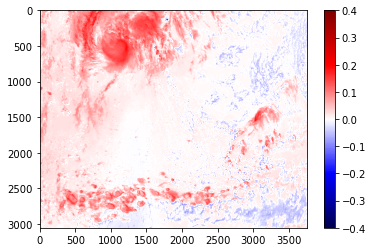

In [30]:
imgplot = plt.imshow(diffs[0], cmap = "seismic", vmin = -0.4, vmax = .4)              
plt.colorbar();

In [ ]:
#return back to raw radiances so can apply image making
DNB_bounds = {'night': [2e-10, 3e-7],
              'full_moon': [1.26e-10, 1e-7],  # curtis
              'new_moon': [2e-11, 1e-9],
              'Miller_full_moon': [-9.5, -8.0]}

return (arr * (mx - mn)) + mn

